# **UNSW-NB15 Intrusion Detection**

> **Dataset**: UNSW-NB15<br>
> **Task**: Binary Classification (Normal vs Attack)<br>
> **Models**: Logistic Regression, Decision Tree, KNN, Naive Bayes, Random Forest, XGBoost<br>
> **Metrics**: Accuracy, AUC, Precision, Recall, F1, MCC

**Name: Ayan Ahmad<br>BITS ID: (2025AA05215)<br>Date: 13-Feb-2026**

In [ ]:
# ------------------------------------------------------------
# 1. IMPORT LIBRARIES
# ------------------------------------------------------------

# Core
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")

# Model Selection & Preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Models
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier

# XGBoost
!pip install xgboost -q
from xgboost import XGBClassifier

# Metrics
from sklearn.metrics import (
    accuracy_score,
    roc_auc_score,
    precision_score,
    recall_score,
    f1_score,
    matthews_corrcoef,
    confusion_matrix
)

# Utilities
import joblib
import os

In [ ]:
# ------------------------------------------------------------
# 2. DATA LOADING AND PREPROCESSING
# ------------------------------------------------------------

# Load Parquet Files
train_df = pd.read_parquet("UNSW_NB15_training-set.parquet")
test_df = pd.read_parquet("UNSW_NB15_testing-set.parquet")

# Combine Train + Test
df = pd.concat([train_df, test_df], axis=0).reset_index(drop=True)

# Drop Multi-class Column
df.drop(columns=["attack_cat"], inplace=True, errors="ignore")

print("Dataset Shape:", df.shape)
print("\nClass Distribution:")
print(df["label"].value_counts())

# Define Features & Target
X = df.drop("label", axis=1)
y = df["label"]

categorical_cols = ['proto', 'service', 'state']
numerical_cols = [col for col in X.columns if col not in categorical_cols]

print("\nCategorical Columns:", list(categorical_cols))
print("Number of Numerical Columns:", len(numerical_cols))

# Stratified Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

print("\nTrain Shape:", X_train.shape)
print("Test Shape:", X_test.shape)

# Column Transformer
preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), numerical_cols),
        ("cat", OneHotEncoder(handle_unknown="ignore", sparse_output=False), categorical_cols)
    ]
)

Dataset Shape: (257673, 35)

Class Distribution:
label
1    164673
0     93000
Name: count, dtype: int64

Categorical Columns: ['proto', 'service', 'state']
Number of Numerical Columns: 31

Train Shape: (206138, 34)
Test Shape: (51535, 34)


In [ ]:
# ------------------------------------------------------------
# 3. MODEL LOADING AND TRAINING
# ------------------------------------------------------------

# Models
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),

    "Decision Tree": DecisionTreeClassifier(
        max_depth=20,
        random_state=42
    ),

    "KNN": KNeighborsClassifier(
        n_neighbors=5
    ),

    "Naive Bayes": GaussianNB(),

    "Random Forest": RandomForestClassifier(
        n_estimators=30,
        max_depth=15,
        random_state=42
    ),

    "XGBoost": XGBClassifier(
        n_estimators=100,
        max_depth=6,
        eval_metric="logloss",
        random_state=42
    )
}


# Training
trained_models = {}
results = []

print("\n" + "="*60)
print("TRAINING MODELS")
print("="*60)

for name, model in models.items():

    print(f"\nTraining: {name}")

    pipeline = Pipeline([
        ("preprocessor", preprocessor),
        ("classifier", model)
    ])

    # Dataset Reduction for KNN
    if name == "KNN":
      preprocessor.fit(X_train)

      X_train_full_transformed = preprocessor.transform(X_train)

      idx = np.random.RandomState(42).choice(
          X_train_full_transformed.shape[0],
          15000,
          replace=False
      )

      X_sub = X_train_full_transformed[idx]
      y_sub = y_train.iloc[idx]

      model.fit(X_sub, y_sub)

      # Rebuilding pipeline manually
      pipeline = Pipeline([
          ("preprocessor", preprocessor),
          ("classifier", model)
      ])

      trained_models[name] = pipeline

    else:
        pipeline.fit(X_train, y_train)

    trained_models[name] = pipeline

    y_pred = pipeline.predict(X_test)
    y_proba = pipeline.predict_proba(X_test)[:, 1]

    # Evaluation
    acc = accuracy_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_proba)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    mcc = matthews_corrcoef(y_test, y_pred)

    results.append([name, acc, auc, prec, rec, f1, mcc])


TRAINING MODELS

Training: Logistic Regression

Training: Decision Tree

Training: KNN

Training: Naive Bayes

Training: Random Forest

Training: XGBoost


In [ ]:
# ------------------------------------------------------------
# 4. MODELS EVALUATION & COMPARISON
# ------------------------------------------------------------

results_df = pd.DataFrame(results, columns=[
    "Model", "Accuracy", "AUC", "Precision", "Recall", "F1", "MCC"
]).round(4)

print("\nMODEL PERFORMANCE COMPARISON\n")
print(results_df.sort_values("MCC", ascending=False))


MODEL PERFORMANCE COMPARISON

                 Model  Accuracy     AUC  Precision  Recall      F1     MCC
5              XGBoost    0.9383  0.9891     0.9540  0.9493  0.9516  0.8666
1        Decision Tree    0.9326  0.9737     0.9590  0.9344  0.9465  0.8558
4        Random Forest    0.9315  0.9872     0.9293  0.9663  0.9474  0.8505
2                  KNN    0.8895  0.9576     0.9074  0.9210  0.9142  0.7591
0  Logistic Regression    0.8713  0.9487     0.8579  0.9572  0.9048  0.7182
3          Naive Bayes    0.5052  0.6669     0.9996  0.2258  0.3684  0.3083


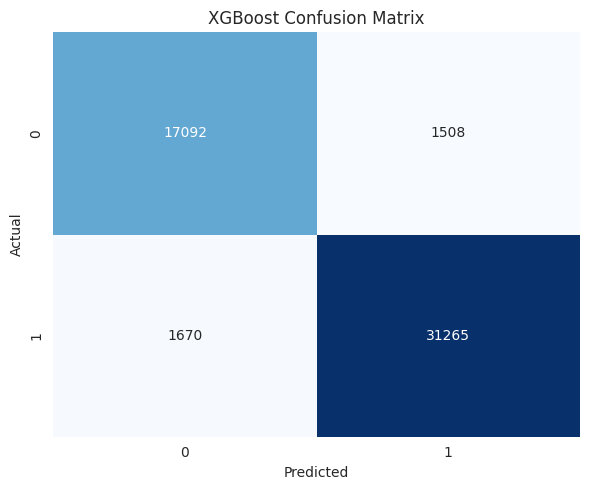

In [ ]:
# ------------------------------------------------------------
# 5. BEST MODEL (XGBoost) CONFUSION MATRIX
# ------------------------------------------------------------

best_model = trained_models["XGBoost"]
y_pred_best = best_model.predict(X_test)

cm = confusion_matrix(y_test, y_pred_best)

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("XGBoost Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()

In [ ]:
# ------------------------------------------------------------
# 6. FILE MANAGEMENT
# ------------------------------------------------------------

# Models
os.makedirs("model", exist_ok=True)

for name, model in trained_models.items():
    filename = name.lower().replace(" ", "_") + ".pkl"
    joblib.dump(model, f"model/{filename}")

print("\nModels saved successfully.")

# CSVs
results_df.to_csv("model_results.csv", index=False)

sample = X_test.copy()
sample["label"] = y_test.values
sample.sample(2000).to_csv("test_sample.csv", index=False)

print("CSV files saved.")

# Verifying File Sizes
print("\nModel File Sizes:")
for file in os.listdir("model"):
    size_mb = os.path.getsize(os.path.join("model", file)) / (1024*1024)
    print(f"{file} → {size_mb:.2f} MB")


Models saved successfully.
CSV files saved.

Model File Sizes:
knn.pkl → 21.41 MB
naive_bayes.pkl → 0.01 MB
xgboost.pkl → 0.30 MB
random_forest.pkl → 3.84 MB
logistic_regression.pkl → 0.01 MB
decision_tree.pkl → 0.43 MB
